In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import urllib2
from operator import itemgetter

from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from string import punctuation

from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
%matplotlib inline  

stop = stopwords.words('english')

/Users/George/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/George/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
austin_data = pd.DataFrame.from_csv('austin_route_text.csv')
frankenjura_data = pd.DataFrame.from_csv('frankenjura_route_text.csv')

In [3]:
def remove_end_line(length):
    return length.replace('\n','')

def route_location_depth(location):
    return len(location.split('>'))

def route_name_length(route_name):
    return len(str(route_name))

def return_clean_grade(rating):
    return rating[0:6]

def return_large_avg_stars(stars):
    num_list = [num for num in stars]
    if num_list[0] in ['-','h','"',' ']:
        return 0
    else:
        return float(num_list[0]+num_list[2])
    
def return_char_count(text):
    text = str(text)
    return len(text.replace(" ","").replace(".",""))

def return_word_count(text):
    text = str(text)
    return len(text.split(" "))

def remove_punctuation(text):
    text = str(text)
    return ''.join(c for c in text if c not in punctuation)

def return_clean_text(text):
    text = str(text)
    return " ".join(remove_punctuation(x.lower()) for x in text.split() if x not in stop)


In [4]:
austin_data['page_text_clean'] = austin_data['page_text'].apply(return_clean_text)
austin_data['comment_text_clean'] = austin_data['comment_text'].apply(return_clean_text)

frankenjura_data['page_text_clean'] = frankenjura_data['page_text'].apply(return_clean_text)
frankenjura_data['comment_text_clean'] = frankenjura_data['comment_text'].apply(return_clean_text)

/Users/George/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [5]:
austin_data = austin_data.drop(['route_soup','Length','comment_text','page_text'], axis=1)
frankenjura_data = frankenjura_data.drop(['route_soup','Length','comment_text','page_text'], axis=1)

In [263]:
#import csv
#austin_data.to_csv('clean_austin_txt.csv', quoting=csv.QUOTE_NONE, quotechar="",  escapechar="\\")
#frankenjura_data.to_csv('clean_frankenjura_txt.csv', quoting=csv.QUOTE_NONE, quotechar="",  escapechar="\\")

In [6]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [223]:
count_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,3), max_features=1000, strip_accents='unicode', stop_words='english')
page_text_count_vect = count_vectorizer.fit_transform(frankenjura_data['page_text_clean'])
page_text_count_df = pd.DataFrame(page_text_count_vect.toarray())
page_text_count_df.columns = [text+'_page_cnt' for text in count_vectorizer.get_feature_names()]

In [224]:
austin_page_text_count_vect = count_vectorizer.transform(austin_data['page_text_clean'])
austin_text_count_df = pd.DataFrame(austin_page_text_count_vect.toarray())
austin_text_count_df.columns = [text+'_page_cnt' for text in count_vectorizer.get_feature_names()]

In [306]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,3), max_features=1000, strip_accents='unicode', stop_words='english')
page_text_tfidf_vect = tfidf_vectorizer.fit_transform(frankenjura_data['page_text_clean'])
page_text_tfidf_df = pd.DataFrame(page_text_tfidf_vect.toarray())
page_text_tfidf_df.columns = [text+'_page_tfidf' for text in tfidf_vectorizer.get_feature_names()]

In [307]:
austin_page_text_tfidf_vect = tfidf_vectorizer.transform(austin_data['page_text_clean'])
austin_text_tfidf_df = pd.DataFrame(austin_page_text_tfidf_vect.toarray())
austin_text_tfidf_df.columns = [text+'_page_tfidf' for text in tfidf_vectorizer.get_feature_names()]

In [227]:
#count_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,1), max_features=1000, strip_accents='unicode', stop_words='english')
#comment_text_count_vect = count_vectorizer.fit_transform(austin_data['comment_text_clean'])
#comment_text_count_df = pd.DataFrame(comment_text_count_vect.toarray())
#comment_text_count_df.columns = [text+'_cmt_cnt' for text in count_vectorizer.get_feature_names()]

In [228]:
#tfidf_vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,1), max_features=1000, strip_accents='unicode', stop_words='english')
#comment_text_tfidf_vect = tfidf_vectorizer.fit_transform(austin_data['comment_text_clean'])
#comment_text_tfidf_df = pd.DataFrame(page_text_tfidf_vect.toarray())
#comment_text_tfidf_df.columns = [text+'_comment_tfidf' for text in tfidf_vectorizer.get_feature_names()]

In [ ]:
page_text_count_df = pd.DataFrame(page_text_count_vect.toarray().toshape(100))
page_text_count_df.columns = [text+'_page_cnt' for text in count_vectorizer.get_feature_names()]

In [302]:
from collections import Counter
counts = austin_page_text_count_vect.sum(axis=0).A1
vocab = list(count_vectorizer.get_feature_names())
freq_distribution = Counter(dict(zip(vocab, counts)))

In [303]:
test_list = freq_distribution.most_common(10)

In [304]:
term_list = []
for rows in test_list:
    term_list.append({'term': rows[0], 'count': rows[1]})

In [305]:
pd.DataFrame(term_list)

,count,term
0,1015,bolt
1,583,anchor
2,486,route
3,486,right
4,469,left
5,332,start
6,250,wall
7,224,roof
8,210,climb
9,197,clip


In [308]:
frankenjura_df = frankenjura_data[["Route","Location","URL","Rating"]]

In [310]:
fj_content_df = pd.concat([frankenjura_df, page_text_tfidf_df], axis=1, join='inner')

In [311]:
austin_df = austin_data[["Route","Location","URL","Rating"]]
austin_content_df = pd.concat([austin_df, austin_text_tfidf_df], axis=1, join='inner')

In [312]:
def assign_group(grade):
    grade = str(grade.replace('"',''))[0:4].replace('+','').replace('-','').strip()
    if grade in ['5.5','5.6','5.7','5.8','5.9']:
        return '1'
    elif grade in ['5.10','5.11']:
        return '2'
    elif grade in ['5.12','5.13','5.14']:
        return '3'
    else:
        return '1'

In [313]:
fj_content_df['category'] = fj_content_df['Rating'].apply(assign_group)

In [314]:
austin_content_df['category'] = austin_content_df['Rating'].apply(assign_group)

In [315]:
y_col = 'category'
x_col = fj_content_df.drop(['Route','Location','Location','Rating','URL','category'],axis=1).columns.values

In [316]:
X_data = fj_content_df[x_col]
Y_data = fj_content_df[y_col]

In [317]:
X_austin_data = austin_content_df[x_col]
Y_austin_data = austin_content_df[y_col]

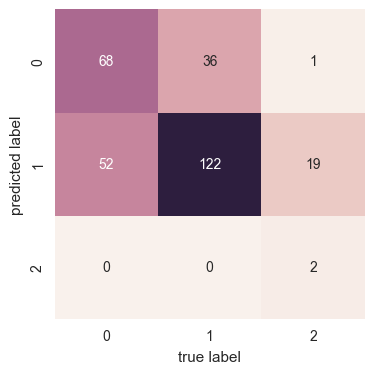

In [318]:
model = MultinomialNB(alpha=1.0)
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [319]:
accuracy_score(y_test, y_pred)

0.64000000000000001

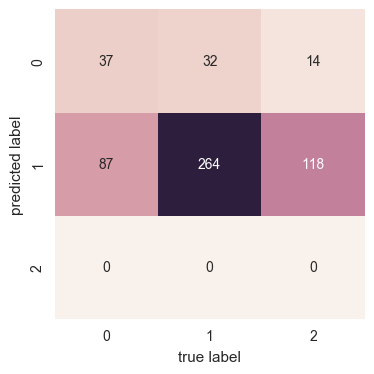

In [320]:
austin_y_pred = model.predict(X_austin_data)
conf_mat = confusion_matrix(Y_austin_data, austin_y_pred)
sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [321]:
accuracy_score(Y_austin_data, austin_y_pred)

0.54528985507246375

In [249]:
nb_feature_df = pd.DataFrame(x_col, columns=['text_features'])
nb_feature_df['1_count'] = model.feature_count_[0]
nb_feature_df['2_count'] = model.feature_count_[1]
nb_feature_df['3_count'] = model.feature_count_[2]

In [268]:
import math

nb_feature_df['1_diff'] = nb_feature_df['1_count']/(nb_feature_df['1_count']+nb_feature_df['2_count'] + nb_feature_df['3_count'])
nb_feature_df['2_diff'] = nb_feature_df['2_count']/(nb_feature_df['1_count']+nb_feature_df['2_count'] + nb_feature_df['3_count'])
nb_feature_df['3_diff'] = nb_feature_df['3_count']/(nb_feature_df['1_count']+nb_feature_df['2_count'] + nb_feature_df['3_count'])

In [269]:
nb_feature_df.sort_values(by='1_diff', ascending=False).head(n=10)

,text_features,1_count,2_count,3_count,1_diff,2_diff,3_diff
620,nice little_page_cnt,8.000000,0.0,0.0,1.0,0.0,0.0
40,55_page_cnt,5.000000,0.0,0.0,1.0,0.0,0.0
1040,55_page_tfidf,0.908214,0.0,0.0,1.0,0.0,0.0
1022,3 sling_page_tfidf,0.916884,0.0,0.0,1.0,0.0,0.0
464,heading left_page_cnt,1.000000,0.0,0.0,1.0,0.0,0.0
465,heading left route_page_cnt,1.000000,0.0,0.0,1.0,0.0,0.0
979,way right_page_cnt,4.000000,0.0,0.0,1.0,0.0,0.0
114,blood_page_cnt,4.000000,0.0,0.0,1.0,0.0,0.0
113,blocky_page_cnt,6.000000,0.0,0.0,1.0,0.0,0.0
929,top2 bolt_page_cnt,5.000000,0.0,0.0,1.0,0.0,0.0


In [270]:
nb_feature_df.sort_values(by='2_diff', ascending=False).head(n=10)

,text_features,1_count,2_count,3_count,1_diff,2_diff,3_diff
1345,easier rock_page_tfidf,0.0,1.235351,0.0,0.0,1.0,0.0
1198,certainly_page_tfidf,0.0,0.986746,0.0,0.0,1.0,0.0
185,bouldery start_page_cnt,0.0,9.000000,0.0,0.0,1.0,0.0
564,linke_page_cnt,0.0,3.000000,0.0,0.0,1.0,0.0
1871,spend_page_tfidf,0.0,0.764383,0.0,0.0,1.0,0.0
1185,bouldery start_page_tfidf,0.0,2.738947,0.0,0.0,1.0,0.0
1190,bump_page_tfidf,0.0,0.452911,0.0,0.0,1.0,0.0
840,skip_page_cnt,0.0,1.000000,0.0,0.0,1.0,0.0
1486,hueco_page_tfidf,0.0,0.645501,0.0,0.0,1.0,0.0
1751,right hand_page_tfidf,0.0,0.714016,0.0,0.0,1.0,0.0


In [271]:
nb_feature_df.sort_values(by='3_diff', ascending=False).head(n=10)

,text_features,1_count,2_count,3_count,1_diff,2_diff,3_diff
39,512_page_cnt,0.0,0.0,3.000000,0.0,0.0,1.0
1838,sinker_page_tfidf,0.0,0.0,0.861137,0.0,0.0,1.0
417,gain_page_cnt,0.0,0.0,4.000000,0.0,0.0,1.0
1446,gullich_page_tfidf,0.0,0.0,1.109759,0.0,0.0,1.0
1417,gain_page_tfidf,0.0,0.0,0.712617,0.0,0.0,1.0
1992,world_page_tfidf,0.0,0.0,0.836101,0.0,0.0,1.0
1039,512_page_tfidf,0.0,0.0,0.709848,0.0,0.0,1.0
838,sinker_page_cnt,0.0,0.0,6.000000,0.0,0.0,1.0
839,sinker pocket_page_cnt,0.0,0.0,5.000000,0.0,0.0,1.0
992,world_page_cnt,0.0,0.0,7.000000,0.0,0.0,1.0


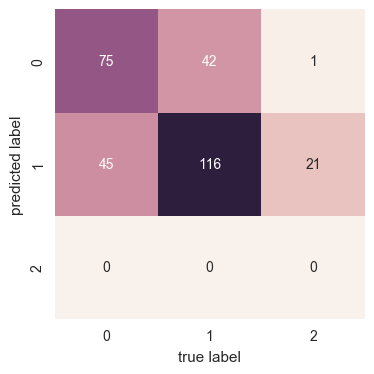

In [322]:
model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [323]:
accuracy_score(y_test, y_pred)

0.63666666666666671

In [218]:
#coef_df['coef_value_1'] = model.coef_[0]
#coef_df['coef_value_1_abs'] = coef_df['coef_value_1'].apply(abs)
#coef_df['coef_value_2'] = model.coef_[1]
#coef_df['coef_value_2_abs'] = coef_df['coef_value_2'].apply(abs)
#coef_df['coef_value_3'] = model.coef_[2]
#coef_df['coef_value_3_abs'] = coef_df['coef_value_3'].apply(abs)

In [219]:
null_accuracy = float(len(austin_content_df[austin_content_df.category=='2']))/float(len(austin_content_df))

In [220]:
print(null_accuracy)

0.536231884058


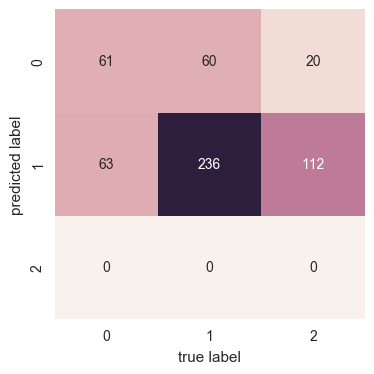

In [324]:
austin_y_pred = model.predict(X_austin_data)
conf_mat = confusion_matrix(Y_austin_data, austin_y_pred)
sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [325]:
accuracy_score(Y_austin_data, austin_y_pred)

0.53804347826086951

In [342]:
pred_df_austin = pd.DataFrame(model.predict_proba(X_austin_data)[:], columns=['1','2','3']).head()

In [359]:
austin_content_df['3_predictions'] = pred_df_austin['3']

In [362]:
austin_content_df[austin_content_df['2_predictions'] > austin_content_df['3_predictions']][austin_content_df.category == '3']

/Users/George/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Route,Location,URL,Rating,1_page_tfidf,1 bolt_page_tfidf,1 bolt anchor_page_tfidf,1 sling_page_tfidf,1 sling anchor_page_tfidf,1 sling pigtail_page_tfidf,...,written_page_tfidf,youd_page_tfidf,youll_page_tfidf,youre_page_tfidf,youve_page_tfidf,youve got_page_tfidf,category,2_predictions,1_predictions,3_predictions
0,Liposuction,"""Sex Cave > Reimer's Ranch > Texas""",https://www.mountainproject.com/route/10586534...,5.12a,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,0.557572,0.236674,0.205754
